<a href="https://colab.research.google.com/github/saugatapaul1010/CIFAR10-ENET-B5/blob/main/CIFAR_10_EfficientNetB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries, Connect With G-Drive, Check GPU Availability

In [ ]:
#Importing all the libraries
from keras.backend import sigmoid
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
import albumentations as albu
from sklearn.metrics import accuracy_score
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History, TensorBoard, Callback, LearningRateScheduler
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import math
from keras.models import load_model
import gc

In [ ]:
#Mounting Gdrive
from google.colab import drive
drive.mount('/gdrive')
model_save_path = "/gdrive/My Drive/CIFAR-10-MODELS"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
#Check GPU Availability
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

os.environ["CUDA_VISIBLE_DEVICES"]="0"

TF version: 2.8.2
GPU is available
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4485076456338959979
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16139419648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16108442674442733933
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


# Helper Functions For Data Visualization and Data Transformations

In [ ]:
def load_data():
    """
    Helper function to prepare the train, vaid, test datasets, for CIFAR-10.
    """
    (X, y), (X_test, y_test) = cifar10.load_data()
    st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1947)

    #Splitting X into X_train, X_val. Keeping X_Test only for testing model's performance on unseen data.
    for train_index, val_index in st.split(X, y):
        X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

    print("The number of training data : ", X_train.shape[0])
    print("The number of validation data : ", X_val.shape[0])
    print("The number of test data : ", X_test.shape[0])

    del X, y

    return X_train, y_train, X_val, y_val, X_test, y_test

def plot_data(class_label_list):
    """
    Helper function to plot sample images from the training set.
    """
    NUM_CLASSES = len(class_label_list)
    class_plotted = np.random.choice(range(len(class_label_list)), NUM_CLASSES, replace = False)

    for i in range(len(class_plotted)):
        image_samples = X_train[y_train.reshape(-1) == class_plotted[i]][:10]
        fig, ax = plt.subplots(nrows = 1, ncols = 10,figsize = (8,8))
        fig.suptitle("Label : %d, Class : %s" % (class_plotted[i], class_label_list[class_plotted[i]]), y = .6)
        for j in range(10):
            ax[j].imshow(image_samples[j])
            ax[j].axis('off')  
        fig.tight_layout()
    plt.show()

    return NUM_CLASSES

# Converting class vectors to binary class matrices
def normalize_images(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Helper function to normalize the datasets"
    """
    y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
    y_val = keras.utils.to_categorical(y_val, NUM_CLASSES)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_val = X_val.astype('float32')
    X_train /= 255
    X_val /= 255
    X_test /= 255

    print("Images Normalized")

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
#Load Dataset CIFAR-10
X_train, y_train, X_val, y_val, X_test, y_test = load_data()

The number of training data :  40000
The number of validation data :  10000
The number of test data :  10000


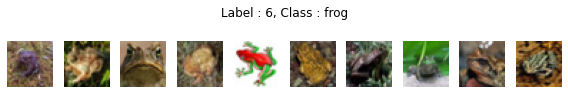

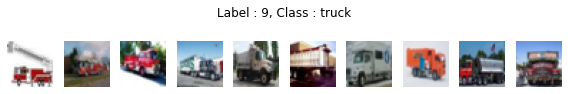

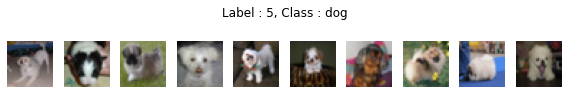

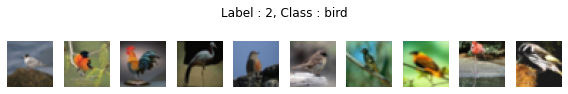

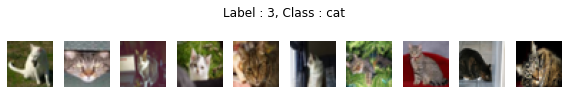

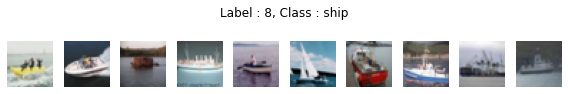

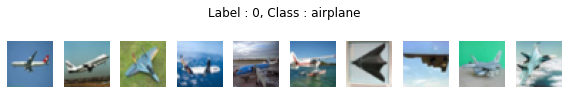

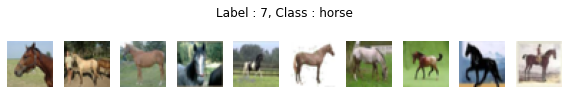

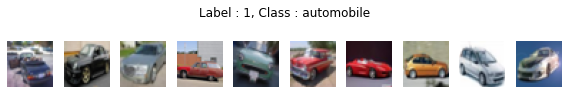

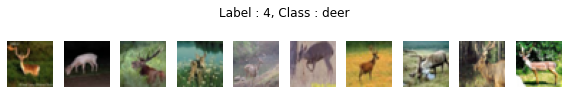

In [ ]:
#Plot the data
class_label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = plot_data(class_label_list)

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = normalize_images(X_train, y_train, X_val, y_val, X_test, y_test)

Images Normalized


# Helper Functions Required For Model Training and Evaluation

In [ ]:
class SwishActivation(Activation):
    """Custom Actvation Function. 
    Reference : https://iq.opengenus.org/swish-activation-function/, 
                https://medium.com/@neuralnets/swish-activation-function-by-google-53e1ea86f820
    """    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler Callback
    implemented using the Keras Callback class.
    References: https://paperswithcode.com/method/cosine-annealing
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)


def adjust_learning_rate(epoch):
    """This function is used if we want to manually decrease 
    the learning rate after specific epochs.
    """
    lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"]
    if epoch >= 10:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 10
    if epoch >= 20:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 100
    if epoch >= 30:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 1000
    if epoch >= 40:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 10000
    if epoch >= 50:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 100000
    if epoch >= 60:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 1000000
    if epoch >= 70:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 10000000
    if epoch >= 80:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 100000000
    return lr

def callbacks_list(input_params):
    """
    This function is used to define custom callbacks. Any new callbacks
    that are to be added to the model must be defined in this function
    and returned as a list of callbacks.
    """    
    base_checkpoint_folder = '/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_{}'.format(input_params["MODEL_NUMBER"])
    checkpoint_filepath = base_checkpoint_folder + '-{epoch:02d}-{val_accuracy:.2f}.h5'    
    checkpoint = ModelCheckpoint(checkpoint_filepath,
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True)
    
    reduce_learning_rate = ReduceLROnPlateau(monitor = input_params['REDUCE_LR_MONITOR'], 
                                             mode = input_params['REDUCE_LR_MODE'] , 
                                             patience = input_params['REDUCE_LR_PATIENCE'], 
                                             factor = input_params['REDUCE_LR_DECAY'], 
                                             min_lr = input_params['REDUCE_MIN_LR'], 
                                             verbose = 1)
    
    early_stop = EarlyStopping(monitor = input_params['EARLY_STOP_MONITOR'], 
                               mode = input_params['EARLY_STOP_MODE'], 
                               patience = input_params['EARLY_STOP_PATIENCE'], 
                               restore_best_weights = True, 
                               verbose = 1)
    
    history = History()

    #!tensorboard --logdir=/home/developer/Desktop/Saugata/logs/
    callbacks = [checkpoint, reduce_learning_rate, history, early_stop]

    if input_params["LR_SCHEDULER"] == 'CosineAnnealing':
        callbacks.append(CosineAnnealingScheduler(T_max=input_params['TRAIN_EPOCHS'], eta_max=0.05, eta_min=4e-4))
    if input_params["LR_SCHEDULER"] == 'LearningRateScheduler':
        callbacks.append(LearningRateScheduler(adjust_learning_rate))
        
    return callbacks

def start_training(input_params):
    """On calling this function, the model
    training will start"""
    model = input_params["MODEL"]
    model.compile(loss='categorical_crossentropy',
                optimizer=input_params["OPTIMIZER"],
                metrics=input_params["EVAL_METRIC"])

    hist = model.fit(X_train, y_train,
                batch_size=input_params['MINIBATCH_SIZE'],
                epochs=input_params['TRAIN_EPOCHS'],
                validation_data=(X_val, y_val),
                callbacks=input_params["CALLBACKS"],
                shuffle=True,
                verbose=1)
    return hist

def evaluate_model(model, X_test, y_test, dataset):
    """This function is used to evaluate the models
    performance across different datasets
    """
    _, acc = model.evaluate(X_test, y_test)
    print("{} Accuracy: {}%".format(dataset, acc*100))

def plot_cm(model, X, y):
    """Function to Plot Confustion Matrices.
    """
    pred = model.predict(X)
    classes = class_label_list
    ax = sns.heatmap(confusion_matrix(np.argmax(y, axis=1),np.argmax(pred, axis=1)), cmap="binary",annot=True,fmt="d")

def train_val_loss(hist):
    """
    Function to check train vs validation loss
    across all the epochs.
    """
    plt.figure(figsize=(20,12))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Val Loss'], loc='upper left')
    plt.show()

# Experiment : **1**


In [ ]:
def build_model_1(input_params):
    """
    This function is used to build the model architecture. Here I am adding 2 
    fully-connected layers to B5. We will modify this function to change the 
    model architecture during each training pass.
    """

    if(input_params['ACTIVATION_TYPE'] == "SWISH"):
        activation_type = swish_act
    elif(input_params['ACTIVATION_TYPE'] == "RELU"):
        activation_type = 'relu'

    base_model = EfficientNetB5(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

    # Adding 2 fully-connected layers to B5.
    x = base_model.output

    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_type)(x)
    x = Dropout(0.6)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_type)(x)

    # Output layer
    prediction_layer = Dense(input_params['NUM_CLASSES'], activation="softmax")(x)

    model_final = Model(inputs = base_model.input, outputs = prediction_layer)
    return model_final

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_loss'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 6
input_params['REDUCE_LR_MONITOR'] = 'val_loss'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 2
input_params['REDUCE_LR_DECAY'] = 0.3
input_params['LR_SCHEDULER'] =  'None' #'LearningRateScheduler'  #'CosineAnnealing'
input_params['REDUCE_MIN_LR'] = 1e-7
input_params['MINIBATCH_SIZE'] = 32
input_params['TRAIN_EPOCHS'] = 50
input_params['ACTIVATION_TYPE'] = "SWISH" #'RELU'
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 1 #ExperimentNumber
input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] = 0.00001

#This function is used to load the model architecture, for each different model architecture, we will create a new function.
input_params["MODEL"] = build_model_1(input_params)
input_params["OPTIMIZER"] = Adam(learning_rate = 0.00001, epsilon=1e-07, amsgrad=False)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

In [ ]:
#Instantiate the model and display the model summary
model_1 = input_params["MODEL"]
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization[0][0]']          
                                                                                              

In [ ]:
hist1 = start_training(input_params)

Epoch 1/50
1250/1250 [==============================] - ETA: 0s - loss: 2.5422 - accuracy: 0.1105
Epoch 1: val_accuracy improved from -inf to 0.15300, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_1-01-0.15.h5
1250/1250 [==============================] - 134s 92ms/step - loss: 2.5422 - accuracy: 0.1105 - val_loss: 2.2611 - val_accuracy: 0.1530 - lr: 1.0000e-05
Epoch 2/50
1250/1250 [==============================] - ETA: 0s - loss: 2.4223 - accuracy: 0.1328
Epoch 2: val_accuracy improved from 0.15300 to 0.20220, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_1-02-0.20.h5
1250/1250 [==============================] - 115s 92ms/step - loss: 2.4223 - accuracy: 0.1328 - val_loss: 2.1881 - val_accuracy: 0.2022 - lr: 1.0000e-05
Epoch 3/50
1250/1250 [==============================] - ETA: 0s - loss: 2.3159 - accuracy: 0.1593
Epoch 3: val_accuracy improved from 0.20220 to 0.23930, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_1-03-0.24.h5
1250/12

In [ ]:
#Train this model for another 50 epochs and see how it performs.

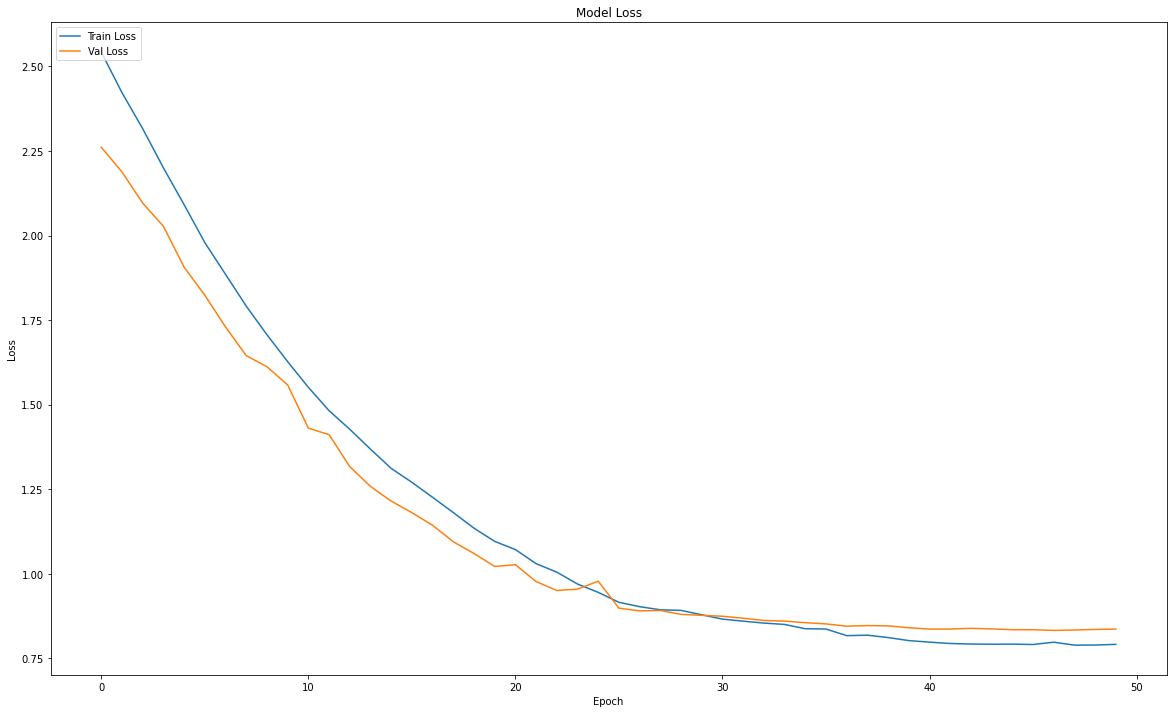

In [ ]:
#As a first step for each experiment, we will visualize the train vs test loss.
train_val_loss(hist1)

In [ ]:
#Load the best model for this iteration
best_model_path = "/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_1-33-0.71.h5"
model_1_final = load_model(best_model_path)

In [ ]:
#Evaluate the loaded model across all datasets
evaluate_model(model_1_final, X_train, y_train, "Train")
evaluate_model(model_1_final, X_val, y_val, "Validation")
evaluate_model(model_1_final, X_test, y_test, "TEST")

1250/1250 [==============================] - 39s 29ms/step - loss: 0.6049 - accuracy: 0.8064
Train Accuracy: 80.64249753952026%
313/313 [==============================] - 13s 33ms/step - loss: 0.8623 - accuracy: 0.7051
Validation Accuracy: 70.50999999046326%
313/313 [==============================] - 11s 34ms/step - loss: 0.8488 - accuracy: 0.7086
TEST Accuracy: 70.85999846458435%


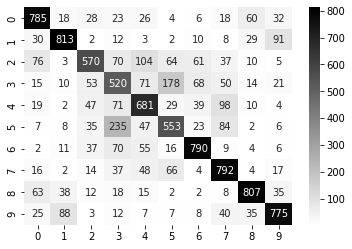

In [ ]:
#Plot Test Confusion Matrix
plot_cm(model_1_final, X_test, y_test)

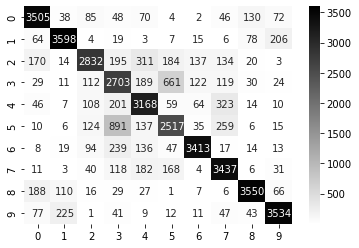

In [ ]:
#Plot Train Confusion Matrix
plot_cm(model_1_final, X_train, y_train, class_label_list)

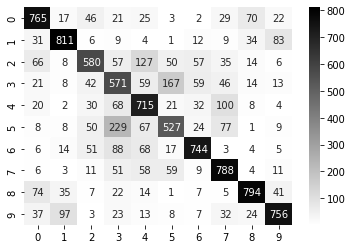

In [ ]:
#Plot Validation Confusion Matrix
plot_cm(model_1_final, X_val, y_val, class_label_list)

In [ ]:
#Removing previous memory allocations
del(input_params)
del(model_1)
del(model_1_final)
gc.collect()

# Experiment : **2**

In this experiment, we are keeping the initial configuration same (the one I have used for model 1), but this time introducing data augmentation. This is to validate, if adding augmentation layers will actually improve the models performance.

In [ ]:
def build_model_2(input_params):
    """
    This function is used to build the model architecture. Here I am adding 2 
    fully-connected layers to B5. We will modify this function to change the 
    model architecture during each training pass. For this function, I am adding
    an augmentation layer, and keeping all the hyparparameters same, to check how's 
    Augmentation affecting our models performance.
    """

    if(input_params['ACTIVATION_TYPE'] == "SWISH"):
        activation_type = swish_act
    elif(input_params['ACTIVATION_TYPE'] == "RELU"):
        activation_type = 'relu'

    #Augmentation layer
    img_augmentation = Sequential(
        [
            layers.RandomRotation(factor=0.15),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            layers.RandomFlip(),
            layers.RandomContrast(factor=0.1),
        ],
        name="img_augmentation",
    )

    inputs = layers.Input(shape=(32, 32, 3))
    x = img_augmentation(inputs)

    base_model = EfficientNetB5(include_top=False, input_tensor=inputs, pooling='avg', weights='imagenet')

    # Adding 2 fully-connected layers to B5.
    x = base_model.output

    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_type)(x)
    x = Dropout(0.6)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_type)(x)

    # Output layer
    prediction_layer = Dense(input_params['NUM_CLASSES'], activation="softmax")(x)

    model_final = Model(inputs = base_model.input, outputs = prediction_layer)
    return model_final

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_loss'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 6
input_params['REDUCE_LR_MONITOR'] = 'val_loss'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 2
input_params['REDUCE_LR_DECAY'] = 0.3
input_params['LR_SCHEDULER'] =  'None' #'LearningRateScheduler'  #'CosineAnnealing'
input_params['REDUCE_MIN_LR'] = 1e-7
input_params['MINIBATCH_SIZE'] = 32
input_params['TRAIN_EPOCHS'] = 100
input_params['ACTIVATION_TYPE'] = "SWISH" #'RELU'
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 2 #ExperimentNumber

#This function is used to load the model architecture, for each different model architecture, we will create a new function.
input_params["MODEL"] = build_model_2(input_params)
input_params["OPTIMIZER"] = Adam(learning_rate = 0.00001, epsilon=1e-07, amsgrad=False)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

In [ ]:
#Instantiate the model and display the model summary
model_2 = input_params["MODEL"]
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization[0][0]']          
                                                                                              

In [ ]:
hist2 = start_training(input_params)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 2.5700 - accuracy: 0.1070
Epoch 1: val_accuracy improved from -inf to 0.15530, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_2-01-0.16.h5
1250/1250 [==============================] - 138s 93ms/step - loss: 2.5700 - accuracy: 0.1070 - val_loss: 2.2569 - val_accuracy: 0.1553 - lr: 1.0000e-05
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 2.4363 - accuracy: 0.1292
Epoch 2: val_accuracy improved from 0.15530 to 0.20720, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_2-02-0.21.h5
1250/1250 [==============================] - 110s 88ms/step - loss: 2.4363 - accuracy: 0.1292 - val_loss: 2.1709 - val_accuracy: 0.2072 - lr: 1.0000e-05
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 2.3215 - accuracy: 0.1603
Epoch 3: val_accuracy improved from 0.20720 to 0.23030, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_2-03-0.23.h5
1250

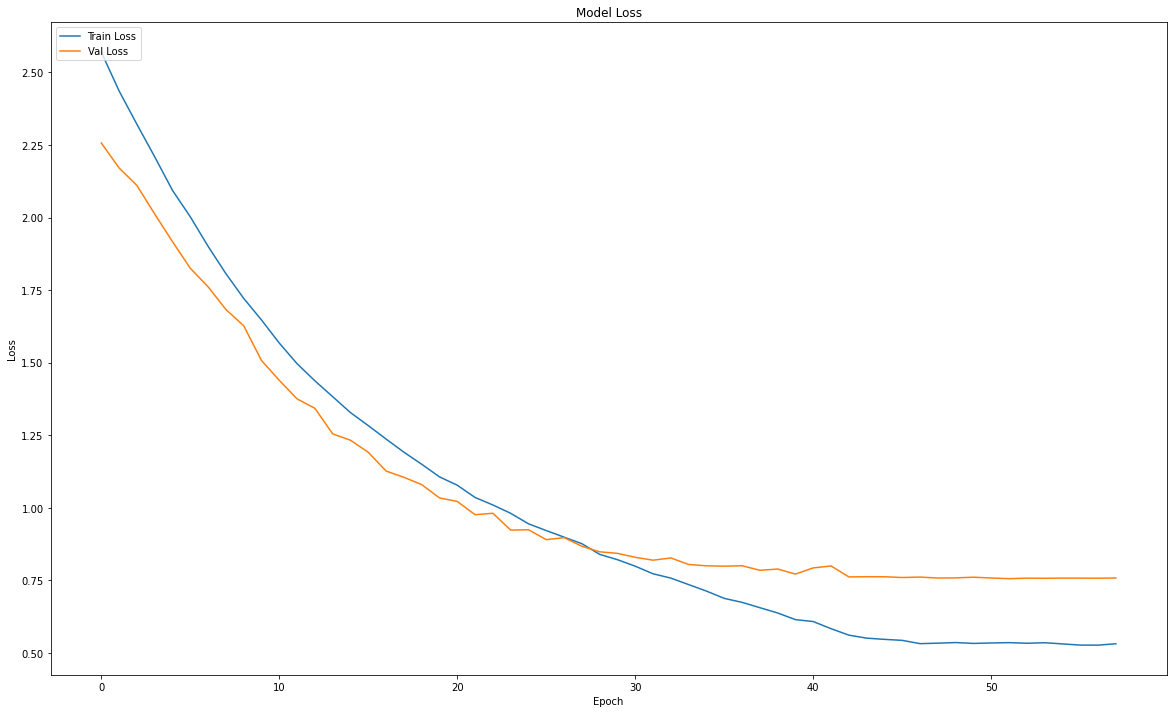

In [ ]:
#As a first step for each experiment, we will visualize the train vs test loss.
train_val_loss(hist2)

In [ ]:
#Load the best model for this iteration
best_model_path = "/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_2-28-0.70.h5"
model_2_final = load_model(best_model_path)

In [ ]:
#Evaluate the loaded model across all datasets
evaluate_model(model_2_final, X_train, y_train, "Train")
evaluate_model(model_2_final, X_val, y_val, "Validation")
evaluate_model(model_2_final, X_test, y_test, "TEST")

1250/1250 [==============================] - 42s 31ms/step - loss: 0.6175 - accuracy: 0.8023
Train Accuracy: 80.23499846458435%
313/313 [==============================] - 15s 35ms/step - loss: 0.8677 - accuracy: 0.7047
Validation Accuracy: 70.46999931335449%
313/313 [==============================] - 11s 35ms/step - loss: 0.8662 - accuracy: 0.7037
TEST Accuracy: 70.37000060081482%


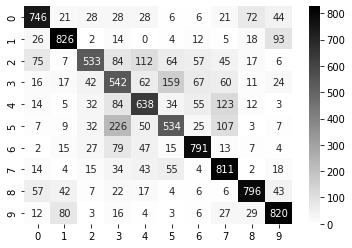

In [ ]:
#Plot Test Confusion Matrix
plot_cm(model_2_final, X_test, y_test)

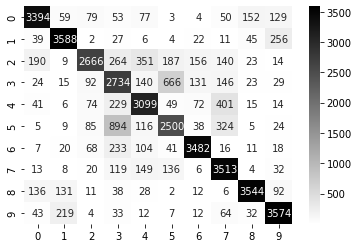

In [ ]:
#Plot Train Confusion Matrix
plot_cm(model_2_final, X_train, y_train)

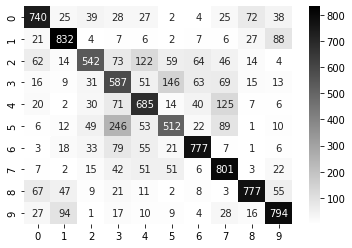

In [ ]:
#Plot Validation Confusion Matrix
plot_cm(model_2_final, X_val, y_val)

# Experiment : **3**

1. Changed Actvation Type to RELU
2. Changed number of epochs to 100, with early stopping.

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_loss'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 6
input_params['REDUCE_LR_MONITOR'] = 'val_loss'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 2
input_params['REDUCE_LR_DECAY'] = 0.3
input_params['LR_SCHEDULER'] =  'None' #'LearningRateScheduler'  #'CosineAnnealing'
input_params['REDUCE_MIN_LR'] = 1e-7
input_params['MINIBATCH_SIZE'] = 32
input_params['TRAIN_EPOCHS'] = 100
input_params['ACTIVATION_TYPE'] = 'RELU' #"SWISH"
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 3 #ExperimentNumber

#Using model 1 architecture
input_params["MODEL"] = build_model_1(input_params)
input_params["OPTIMIZER"] = Adam(learning_rate = 0.00001, epsilon=1e-07, amsgrad=False)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

In [ ]:
#Instantiate the model and display the model summary
model_3 = input_params["MODEL"]
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization[0][0]']          
                                                                                              

In [ ]:
hist3 = start_training(input_params)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 2.6322 - accuracy: 0.1045
Epoch 1: val_accuracy improved from -inf to 0.12540, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_3-01-0.13.h5
1250/1250 [==============================] - 169s 105ms/step - loss: 2.6322 - accuracy: 0.1045 - val_loss: 2.2881 - val_accuracy: 0.1254 - lr: 1.0000e-05
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 2.4794 - accuracy: 0.1186
Epoch 2: val_accuracy improved from 0.12540 to 0.16980, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_3-02-0.17.h5
1250/1250 [==============================] - 127s 102ms/step - loss: 2.4794 - accuracy: 0.1186 - val_loss: 2.2089 - val_accuracy: 0.1698 - lr: 1.0000e-05
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 2.3575 - accuracy: 0.1503
Epoch 3: val_accuracy improved from 0.16980 to 0.19080, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_3-03-0.19.h5
12

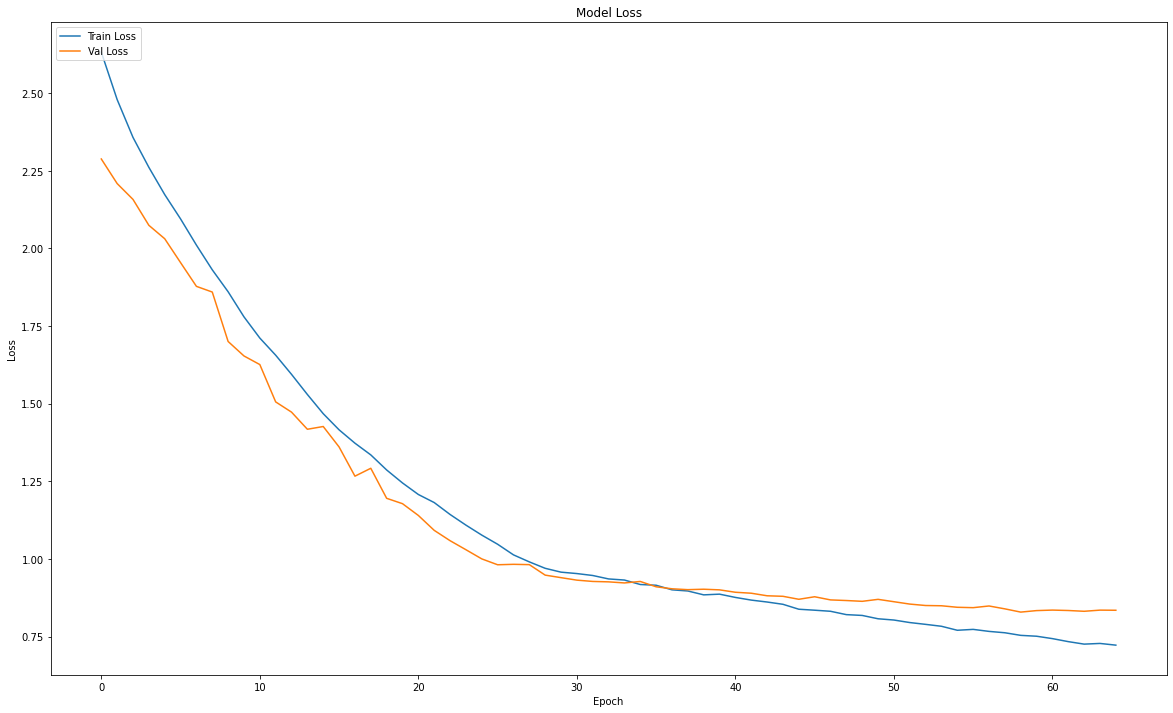

In [ ]:
#As a first step for each experiment, we will visualize the train vs test loss.
train_val_loss(hist3)

In [ ]:
#Load the best model for this iteration
best_model_path = "/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_3-35-0.71.h5"
model_3_final = load_model(best_model_path)

In [ ]:
#Evaluate the loaded model across all datasets
evaluate_model(model_3_final, X_train, y_train, "Train")
evaluate_model(model_3_final, X_val, y_val, "Validation")
evaluate_model(model_3_final, X_test, y_test, "TEST")

1250/1250 [==============================] - 41s 30ms/step - loss: 0.5042 - accuracy: 0.8389
Train Accuracy: 83.88749957084656%
313/313 [==============================] - 13s 33ms/step - loss: 0.8442 - accuracy: 0.7078
Validation Accuracy: 70.77999711036682%
313/313 [==============================] - 10s 33ms/step - loss: 0.8282 - accuracy: 0.7140
TEST Accuracy: 71.39999866485596%


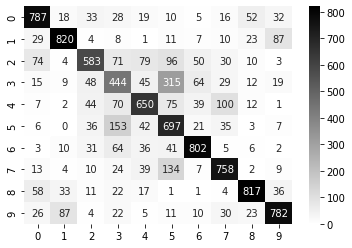

In [ ]:
#Plot Test Confusion Matrix
plot_cm(model_3_final, X_test, y_test)

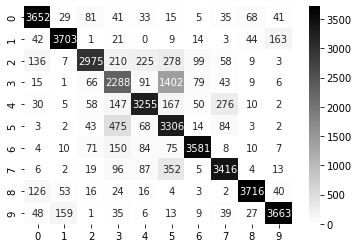

In [ ]:
#Plot Train Confusion Matrix
plot_cm(model_3_final, X_train, y_train)

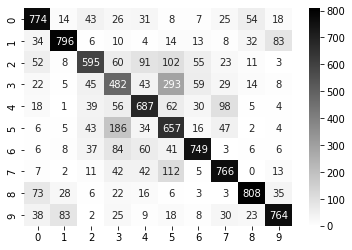

In [ ]:
#Plot Validation Confusion Matrix
plot_cm(model_3_final, X_val, y_val)

In [ ]:
#Removing previous memory allocations
del(input_params)
del(model_3)
del(model_3_final)
gc.collect()

31184

# Experiment : **4**


In [ ]:
def build_model_4(input_params):
    """
    This function is used to build the model architecture. Here I am adding 2 
    fully-connected layers to B5. We are also unfreezing only the top 25 layers,
    and keep the remaining layers frozen.
    """

    if(input_params['ACTIVATION_TYPE'] == "SWISH"):
        activation_type = swish_act
    elif(input_params['ACTIVATION_TYPE'] == "RELU"):
        activation_type = 'relu'
    elif(input_params['ACTIVATION_TYPE'] == "LeakyReLU"):
        activation_type = LeakyReLU(alpha=0.35)

    base_model = EfficientNetB5(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')
    base_model.trainable = False

    # Adding 2 fully-connected layers to B5.
    x = base_model.output

    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_type)(x)
    x = Dropout(0.6)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_type)(x)

    # Output layer
    prediction_layer = Dense(input_params['NUM_CLASSES'], activation="softmax")(x)
    model_final = Model(inputs = base_model.input, outputs = prediction_layer)
    model_final.compile(optimizer=input_params["OPTIMIZER"], loss="categorical_crossentropy", metrics=["accuracy"])
    return model_final

def unfreeze_model(model, input_params):
    # We unfreeze the top 25 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-25:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    model.compile(optimizer=input_params["OPTIMIZER"], loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_accuracy'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 6
input_params['REDUCE_LR_MONITOR'] = 'val_accuracy'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 2
input_params['REDUCE_LR_DECAY'] = 0.3
input_params['LR_SCHEDULER'] =  'LearningRateScheduler' #'LearningRateScheduler'  #'CosineAnnealing'
input_params['REDUCE_MIN_LR'] = 1e-7
input_params['MINIBATCH_SIZE'] = 128
input_params['TRAIN_EPOCHS'] = 100
input_params['ACTIVATION_TYPE'] = "LeakyReLU" #'RELU'
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 1 #ExperimentNumber
input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] = 0.0005
input_params["OPTIMIZER"] = Adadelta(learning_rate = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"])

#This function is used to load the model architecture, for each different model architecture, we will create a new function.
model = build_model_4(input_params)

#Ungfreezing the top layers
input_params["MODEL"] = unfreeze_model(model, input_params)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

In [ ]:
#Instantiate the model and display the model summary
model_4 = input_params["MODEL"]
model_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_3 (Rescaling)        (None, 32, 32, 3)    0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 32, 32, 3)   7           ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_3[0][0]']  

In [ ]:
hist4 = start_training(input_params)

Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 2.6587 - accuracy: 0.0997
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_1-01-0.10.h5
313/313 [==============================] - 40s 84ms/step - loss: 2.6587 - accuracy: 0.0997 - val_loss: 2.3221 - val_accuracy: 0.1000 - lr: 5.0000e-04
Epoch 2/100
312/313 [============================>.] - ETA: 0s - loss: 2.6459 - accuracy: 0.1010
Epoch 2: val_accuracy did not improve from 0.10000
313/313 [==============================] - 21s 66ms/step - loss: 2.6459 - accuracy: 0.1010 - val_loss: 2.3205 - val_accuracy: 0.1000 - lr: 5.0000e-04
Epoch 3/100
312/313 [============================>.] - ETA: 0s - loss: 2.6499 - accuracy: 0.0981
Epoch 3: val_accuracy did not improve from 0.10000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
313/313 [==============================] - 21s 66ms/step - loss: 2.6499 - accuracy: 0.0981 - val_loss

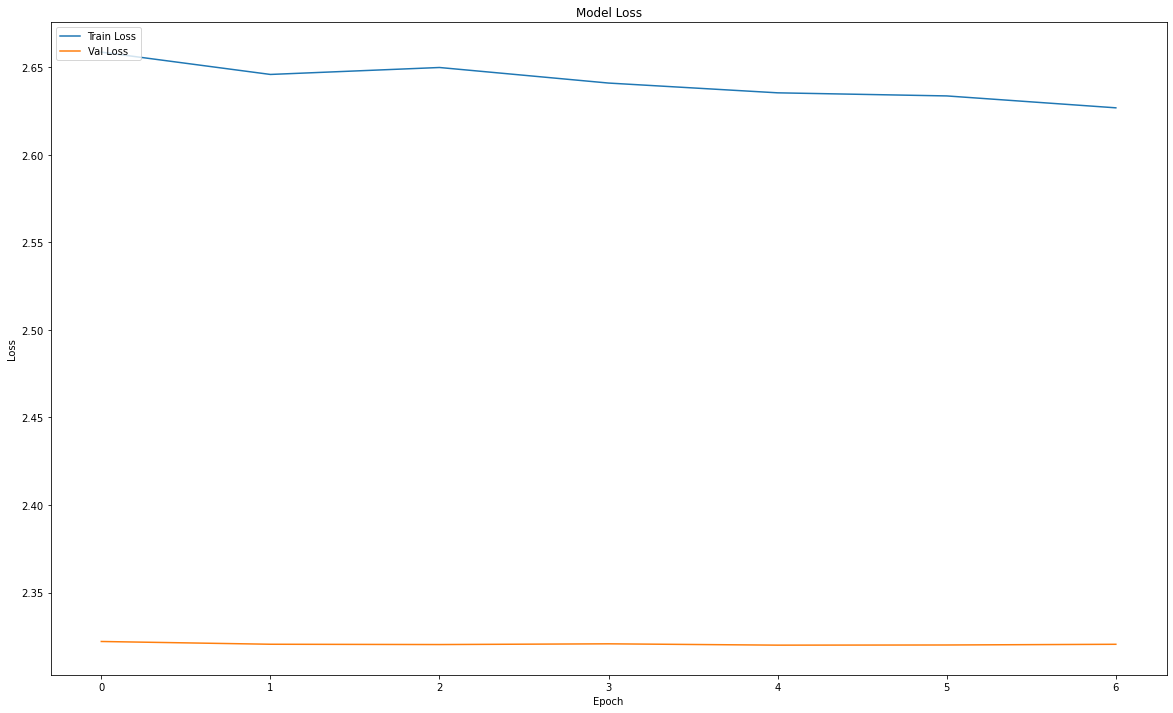

In [ ]:
#As a first step for each experiment, we will visualize the train vs test loss.
train_val_loss(hist4)

In [ ]:
#Load the best model for this iteration
model_4_final = model_4

In [ ]:
#Evaluate the loaded model across all datasets
evaluate_model(model_4_final, X_train, y_train, "Train")
evaluate_model(model_4_final, X_val, y_val, "Validation")
evaluate_model(model_4_final, X_test, y_test, "TEST")

1250/1250 [==============================] - 39s 29ms/step - loss: 2.3278 - accuracy: 0.1018
Train Accuracy: 10.175000131130219%
313/313 [==============================] - 9s 30ms/step - loss: 2.3245 - accuracy: 0.1037
Validation Accuracy: 10.369999706745148%
313/313 [==============================] - 9s 29ms/step - loss: 2.3292 - accuracy: 0.1003
TEST Accuracy: 10.029999911785126%


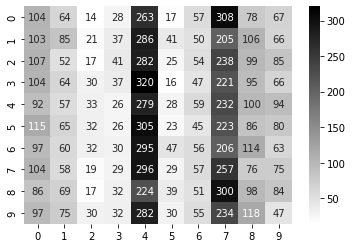

In [ ]:
#Plot Test Confusion Matrix
plot_cm(model_4_final, X_test, y_test)

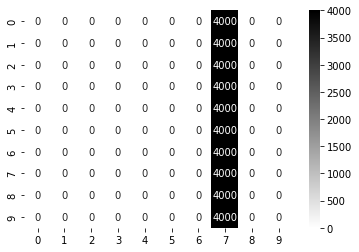

In [ ]:
#Plot Train Confusion Matrix
plot_cm(model_4_final, X_train, y_train)

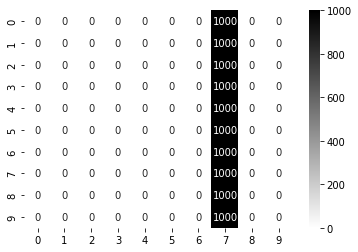

In [ ]:
#Plot Validation Confusion Matrix
plot_cm(model_4_final, X_val, y_val)

In [ ]:
#Removing previous memory allocations
del(input_params)
del(model_4)
del(model_4_final)
gc.collect()

30185

# Experiment : **5**

In this experiment, we are keeping the initial configuration same (the one I have used for model 1), but this time introducing data augmentation. This is to validate, if adding augmentation layers will actually improve the models performance.

In [ ]:
def build_model_5(input_params):
    """
    This function is used to build the model architecture. Here I am adding 2 
    fully-connected layers to B5. We will modify this function to change the 
    model architecture during each training pass. For this function, I am adding
    an augmentation layer, and keeping all the hyparparameters same, to check how's 
    Augmentation affecting our models performance.
    """

    if(input_params['ACTIVATION_TYPE'] == "SWISH"):
        activation_type = swish_act
    elif(input_params['ACTIVATION_TYPE'] == "RELU"):
        activation_type = 'relu'

    base_model = EfficientNetB5(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

    # Adding 2 fully-connected layers to B5.
    x = base_model.output

    x = BatchNormalization()(x)
    x = Dropout(0.75)(x)

    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation(swish_act)(x)
    x = Dropout(0.80)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation(swish_act)(x)
    x = Dropout(0.75)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation(swish_act)(x)
    x = Dropout(0.70)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation(swish_act)(x)

    # Output layer
    prediction_layer = Dense(input_params['NUM_CLASSES'], activation="softmax")(x)

    model_final = Model(inputs = base_model.input, outputs = prediction_layer)
    return model_final

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_loss'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 6
input_params['REDUCE_LR_MONITOR'] = 'val_loss'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 2
input_params['REDUCE_LR_DECAY'] = 0.3
input_params['LR_SCHEDULER'] =  "LearningRateScheduler"
input_params['REDUCE_MIN_LR'] = 1e-7
input_params['MINIBATCH_SIZE'] = 32
input_params['TRAIN_EPOCHS'] = 100
input_params['ACTIVATION_TYPE'] = 'RELU'
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 5 #ExperimentNumber
input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] = 0.00001

#This function is used to load the model architecture, for each different model architecture, we will create a new function.
input_params["MODEL"] = build_model_5(input_params)
input_params["OPTIMIZER"] = Adam(learning_rate = 0.00001, epsilon=1e-07, amsgrad=False)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

In [ ]:
#Instantiate the model and display the model summary
model_5 = input_params["MODEL"]
model_5.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_1[0][0]']  

In [ ]:
hist5 = start_training(input_params)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 2.5683 - accuracy: 0.1015
Epoch 1: val_accuracy improved from -inf to 0.10030, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_5-01-0.10.h5
1250/1250 [==============================] - 155s 105ms/step - loss: 2.5683 - accuracy: 0.1015 - val_loss: 2.3075 - val_accuracy: 0.1003 - lr: 1.0000e-05
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 2.5257 - accuracy: 0.1050
Epoch 2: val_accuracy did not improve from 0.10030
1250/1250 [==============================] - 124s 99ms/step - loss: 2.5257 - accuracy: 0.1050 - val_loss: 2.3070 - val_accuracy: 0.1002 - lr: 1.0000e-05
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 2.4952 - accuracy: 0.1056
Epoch 3: val_accuracy did not improve from 0.10030
1250/1250 [==============================] - 120s 96ms/step - loss: 2.4952 - accuracy: 0.1056 - val_loss: 2.3046 - val_accuracy: 0.1001 - lr: 1.0000e-05
Epoch 4/100


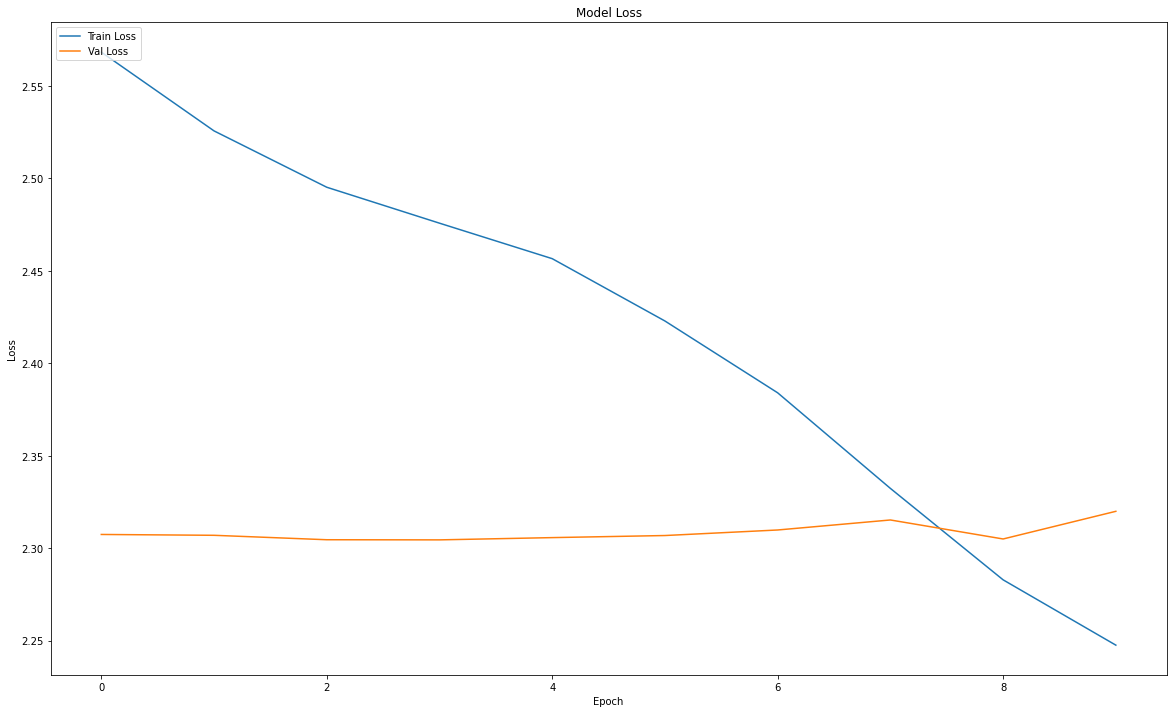

In [ ]:
#As a first step for each experiment, we will visualize the train vs test loss.
train_val_loss(hist5)

In [ ]:
#Load the best model for this iteration --> Not loading the best model, because it's pointless
model_5_final = model_5

In [ ]:
#Evaluate the loaded model across all datasets
evaluate_model(model_5_final, X_train, y_train, "Train")
evaluate_model(model_5_final, X_val, y_val, "Validation")
evaluate_model(model_5_final, X_test, y_test, "TEST")

1250/1250 [==============================] - 44s 32ms/step - loss: 2.3044 - accuracy: 0.1001
Train Accuracy: 10.005000233650208%
313/313 [==============================] - 10s 30ms/step - loss: 2.3045 - accuracy: 0.1000
Validation Accuracy: 10.000000149011612%
313/313 [==============================] - 9s 30ms/step - loss: 2.3042 - accuracy: 0.1001
TEST Accuracy: 10.010000318288803%


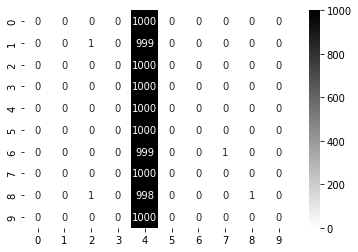

In [ ]:
#Plot Test Confusion Matrix
plot_cm(model_5_final, X_test, y_test)

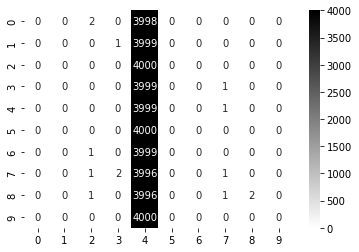

In [ ]:
#Plot Train Confusion Matrix
plot_cm(model_5_final, X_train, y_train)

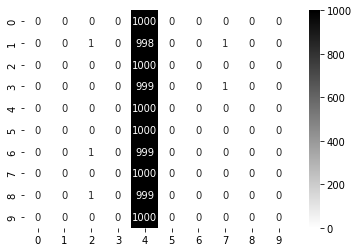

In [ ]:
#Plot Validation Confusion Matrix
plot_cm(model_5_final, X_val, y_val)

# Experiment : 6

In [ ]:
def build_model_6(input_params):
    """
    This function is used to build the model architecture. Here I am adding 2 
    fully-connected layers to B5. We will modify this function to change the 
    model architecture during each training pass.
    """

    if(input_params['ACTIVATION_TYPE'] == "SWISH"):
        activation_type = swish_act
    elif(input_params['ACTIVATION_TYPE'] == "RELU"):
        activation_type = 'relu'

    base_model = EfficientNetB5(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

    # Adding 2 fully-connected layers to B5.
    x = base_model.output

    x = BatchNormalization()(x)
    x = Dropout(0.75)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_type)(x)
    x = Dropout(0.65)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_type)(x)

    # Output layer
    prediction_layer = Dense(input_params['NUM_CLASSES'], activation="softmax")(x)

    model_final = Model(inputs = base_model.input, outputs = prediction_layer)
    return model_final

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_loss'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 6
input_params['REDUCE_LR_MONITOR'] = 'val_loss'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 2
input_params['REDUCE_LR_DECAY'] = 0.4
input_params['LR_SCHEDULER'] =  'None'
input_params['REDUCE_MIN_LR'] = 1e-7
input_params['MINIBATCH_SIZE'] = 64
input_params['TRAIN_EPOCHS'] = 150
input_params['ACTIVATION_TYPE'] = "SWISH" #'RELU'
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 6 #ExperimentNumber

#This function is used to load the model architecture, for each different model architecture, we will create a new function.
input_params["MODEL"] = build_model_6(input_params)
input_params["OPTIMIZER"] = Adam(learning_rate = 0.0001, epsilon=1e-07, amsgrad=False)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

In [ ]:
#Instantiate the model and display the model summary
model_6 = input_params["MODEL"]
model_6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization[0][0]']          
                                                                                              

In [ ]:
hist6 = start_training(input_params)

Epoch 1/150
625/625 [==============================] - ETA: 0s - loss: 2.2882 - accuracy: 0.1618
Epoch 1: val_accuracy improved from -inf to 0.18530, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_6-01-0.19.h5
625/625 [==============================] - 86s 106ms/step - loss: 2.2882 - accuracy: 0.1618 - val_loss: 2.2236 - val_accuracy: 0.1853 - lr: 1.0000e-04
Epoch 2/150
625/625 [==============================] - ETA: 0s - loss: 1.7661 - accuracy: 0.3623
Epoch 2: val_accuracy improved from 0.18530 to 0.43280, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_6-02-0.43.h5
625/625 [==============================] - 63s 100ms/step - loss: 1.7661 - accuracy: 0.3623 - val_loss: 1.6417 - val_accuracy: 0.4328 - lr: 1.0000e-04
Epoch 3/150
625/625 [==============================] - ETA: 0s - loss: 1.3850 - accuracy: 0.5199
Epoch 3: val_accuracy improved from 0.43280 to 0.53620, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_6-03-0.54.h5
625/625 [=====

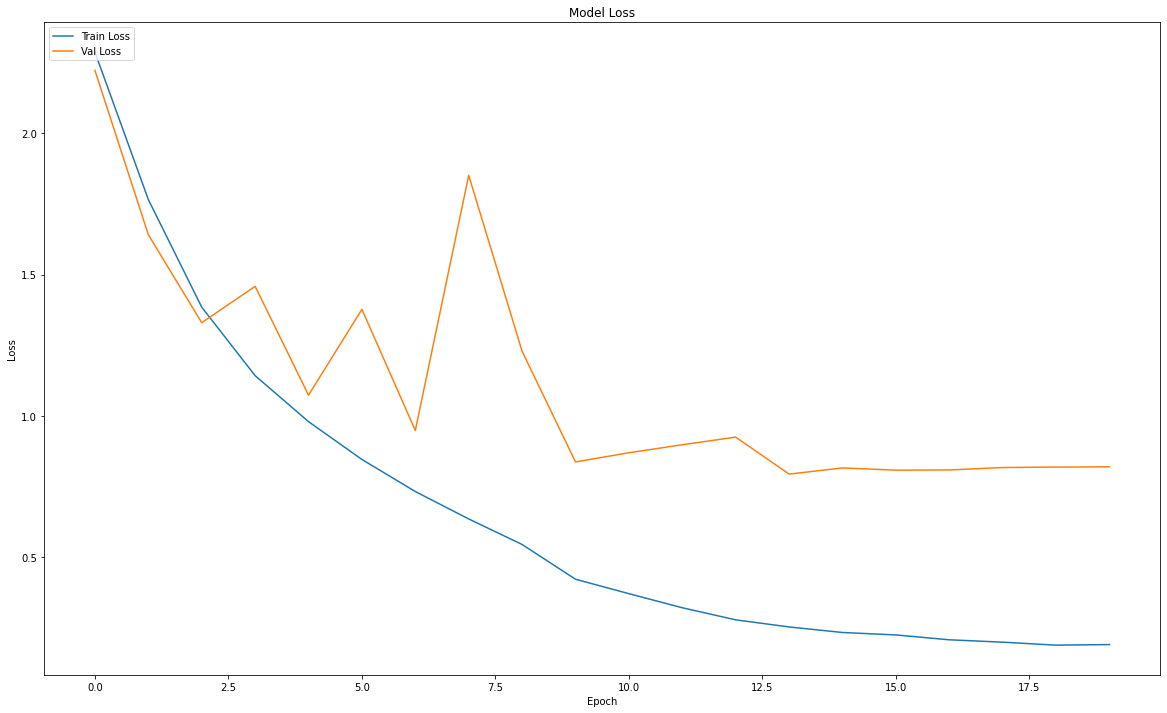

In [ ]:
#As a first step for each experiment, we will visualize the train vs test loss.
train_val_loss(hist6)

In [ ]:
#Load the best model for this iteration
best_model_path = "/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_6-01-0.19.h5"
model_6_final = load_model(best_model_path)

In [ ]:
#Evaluate the loaded model across all datasets
evaluate_model(model_6_final, X_train, y_train, "Train")
evaluate_model(model_6_final, X_val, y_val, "Validation")
evaluate_model(model_6_final, X_test, y_test, "TEST")

1250/1250 [==============================] - 39s 28ms/step - loss: 2.2215 - accuracy: 0.1822
Train Accuracy: 18.217499554157257%
313/313 [==============================] - 12s 30ms/step - loss: 2.2236 - accuracy: 0.1853
Validation Accuracy: 18.529999256134033%
313/313 [==============================] - 10s 31ms/step - loss: 2.2231 - accuracy: 0.1766
TEST Accuracy: 17.659999430179596%


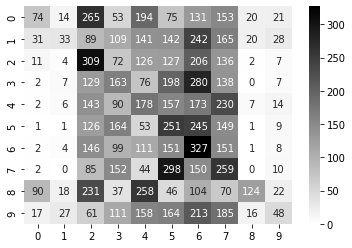

In [ ]:
#Plot Test Confusion Matrix
plot_cm(model_6_final, X_test, y_test)

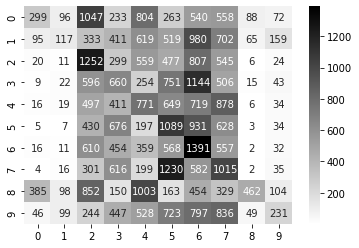

In [ ]:
#Plot Train Confusion Matrix
plot_cm(model_6_final, X_train, y_train)

In [ ]:
#Plot Validation Confusion Matrix
plot_cm(model_6_final, X_val, y_val)

In [ ]:
#Removing previous memory allocations
del(input_params)
del(model_6_final)
del(model_6_final)
gc.collect()

#Key Observations:

Experiment 1 --

1. The train loss and validation loss reduces gradually (i.e. gradient updates are very smooth) and is seen to converge between epoch 27 and 32. Beyond epoch 32, the curves starts diverging which implies the model is getting overfitted to the train data.
2. Initially lower dropout rate was used which was later increased to have more aggressive dropout, to deal with overfitting.
3. Using a much much lower learning rate and training the model for more number of epochs will help further to reduce the most optimal solution. 
4. A partial overfit can be seen even when selecting the models between epoch 27 and 32.
5. More hyper parameter tuning needs to be done to improve the model's performance.

Experiment 2 --

1. Beyond epoch 30, the losses starts diverging and overfitting increases.
2. Optimal model is generated around epoch 30. 
3. Image augmentation improved the performance of the model very minutely.
4. Image Augmentation is slightly overfitting the model.

Experiment 3 --

1. Using the same architecture as model 1, but with RELU.
1. Here also a gradual decrease in train and  validation loss is seen, but the losses starts diverging beyond epoch 40.
2. Partial overfit is observed.
3. Gradient updates are not as smooth as Model with (Because of RELU as compared t SWISH)

Experiment 4, 5, 6 --

1. For 4 and 5, the validation loss remains constant around 2.32
2. Experiment with different optimizers, model architecture, learning rate, activation (leaky relu)
3. The losses doesn't converge at all.
4. For 6, the gradient updates are very nosiy, and the model have not converged at all across multiple tried for the last experiment 6.



Clearly all the top 3 performing models shows signs of partial overfitting. Few things that can be tried to reduce the overfitting much more is to reduce the learning rate combined with reduced batch size and train the model for significantly much larger epochs and check if it improves model performance as well as reduce model overfitting even more. Used cosine-annealing scheduler, reduce learning rate scheduler to deal with overfitting. We can also use Hough Transormation on the input images and check if it improves the model performance and reduces overfitting more. The scope for further experimentation is huge but it needs a very good compute engine and sufficient time to try out more techniques.

# Consolidated Results

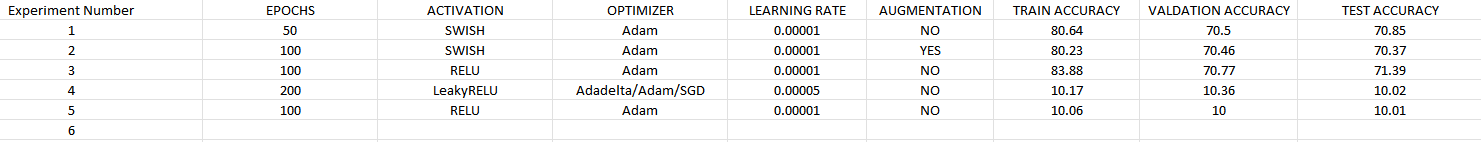